In [122]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta

In [123]:
# Loading the data from files

# More detailed documentation can be found here:
#        https://mimic.mit.edu/docs/iii/tables/
# Data can be found here:
#        https://physionet.org/content/mimiciii/1.4/
# We are loading 
#        admissions - data from admission of a patient, links to patients on subject_id
#        patients   - data defining a patient, pk is subject_id
#        icustays   - data about one stay in the ICU, links to subject_id
#        procedures - data for each procedure, fk subject_id
#        prescriptions - data about prescription made (perhaps cancelled later), fk subject_id
#        labevents  - data for each lab test done, fk subject id
#        microbiologyvents - data for each microbiology event, fk subject_id

df_admissions = pd.read_csv('data/ADMISSIONS.csv', 
                           usecols=['ROW_ID', 'SUBJECT_ID','INSURANCE','LANGUAGE','RELIGION',
                                    'MARITAL_STATUS','ETHNICITY','EDREGTIME','EDOUTTIME',
                                    'HOSPITAL_EXPIRE_FLAG'])
df_patients = pd.read_csv('data/PATIENTS.csv', 
                          usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'DOD'])
df_icustays = pd.read_csv('data/ICUSTAYS.csv', 
                          usecols=['SUBJECT_ID', 'ICUSTAY_ID', 'LOS'])
#df_procedures = pd.read_csv('data/PROCEDURES_ICD.csv')
df_prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv', 
                               usecols=['ROW_ID','SUBJECT_ID'], 
                               dtype={'ROW_ID': int, 'SUBJECT_ID': int})
df_labevents = pd.read_csv('data/LABEVENTS.csv',
                           usecols=['ROW_ID','SUBJECT_ID'], 
                           dtype={'ROW_ID': int, 'SUBJECT_ID': int})
df_microbiologyevents = pd.read_csv('data/MICROBIOLOGYEVENTS.csv',
                                    usecols=['ROW_ID','SUBJECT_ID'],
                                    dtype={'ROW_ID': int, 'SUBJECT_ID': int})

#column names to lowercase
df_admissions.columns = df_admissions.columns.str.lower()
df_patients.columns = df_patients.columns.str.lower()
df_icustays.columns = df_icustays.columns.str.lower()
#df_procedures.columns = df_procedures.columns.str.lower()
df_prescriptions.columns = df_prescriptions.columns.str.lower()
df_labevents.columns = df_labevents.columns.str.lower()
df_microbiologyevents.columns = df_microbiologyevents.columns.str.lower()

#print(df_microbiologyevents.shape)
#print(df_microbiologyevents.head(25))

In [124]:
# Processing the ADMISSIONS table

# Sorting (ascending, so missing values are last), to minimize data loss
# we keep the first row with subject_id and demographic info
df_demographics = (
    df_admissions
    .drop(columns=['edregtime', 'edouttime', 'hospital_expire_flag'])
    .sort_values(by=['subject_id','insurance','language','religion','marital_status','ethnicity'])
    .groupby('subject_id')
    .first()
    .reset_index()
    .drop(columns=['row_id'])
)

#length of stay - admissions table (edouttime - edregtime), average per patient
df_admissions['edregtime']=pd.to_datetime(df_admissions['edregtime'])
df_admissions['edouttime']=pd.to_datetime(df_admissions['edouttime'])
df_admissions['los'] = list(map(lambda d: d/timedelta(days=1), 
                                (df_admissions['edouttime']-df_admissions['edregtime'])))
df_los_avg = (
    df_admissions
    .groupby('subject_id')
    .los
    .mean()
    .reset_index()
    .rename(columns={"los": "los_avg_admis"})
)
#add to demographics df
df_demographics = pd.merge(df_demographics, df_los_avg, on="subject_id")

# This column needs to be sorted in descending order to keep 
# the last hospital visit per subject_id
df_expire_sorted = (
    df_admissions
    .loc[:, ['subject_id','hospital_expire_flag']] 
    .sort_values(by=['subject_id','hospital_expire_flag'], ascending=False)
    .groupby('subject_id')
    .first()
    .reset_index()
)

#Merge the demographics and expire df
df_admi = pd.merge(df_demographics, df_expire_sorted, on="subject_id")

#count number of hospital admissions per patient (subject_id)
admission_count = (
    df_admissions
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_admis"})
    .loc[:, ['subject_id', 'num_admis']] 
)

#Merge the admissions count into the df
df_admissions = pd.merge(df_admi, admission_count, on="subject_id")
#print(df_demographics.head(25))

In [125]:
# Processing the PATIENTS table

#calculate age here dod-dob

#merge condensed admissions with the patients df
df = pd.merge(df_admissions, df_patients, on="subject_id") 

#print("Admissions:\n",df_admissions.count(),"\n")
#print("Patients:\n", df_patients.count(),"\n")
#print("Merged:\n", df.count())

In [126]:
# Processing the ICUSTAYS table

#calculate avg icu stay by subject_id
df_los_icu = (
    df_icustays
    .groupby('subject_id')
    .los
    .mean()
    .reset_index()
    .rename(columns={'los': 'los_avg_icu'})
)
#print(df_los_icu.head(25))
#print(len(df_los_icu))

#merge to include in df
df = df.join(df_los_icu.set_index('subject_id'), on='subject_id')

In [127]:
# Processing the PRESCRIPTIONS table

#calculate total num of prescriptions by subject_id
df_num_pres = (
    df_prescriptions
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_pres"})
    .loc[:, ['subject_id', 'num_pres']] 
)
#print(df_num_pres.head(25))
#print(len(df_num_pres))

#merge to include in df
df = df.join(df_num_pres.set_index('subject_id'), on='subject_id')


In [128]:
# Processing the LABEVENTS table

#calculate total num of labs by subject_id
df_num_labs = (
    df_labevents
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_labs"})
    .loc[:, ['subject_id', 'num_labs']] 
)
#print(df_num_labs.head(25))
#print(len(df_num_labs))

#merge to include in df
df = df.join(df_num_labs.set_index('subject_id'), on='subject_id')


In [129]:
# Processing the MICROBIOLOGYEVENTS table

#calculate total num of microbiology labs by subject_id
df_num_microbio_labs = (
    df_microbiologyevents
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_microbio_labs"})
    .loc[:, ['subject_id', 'num_microbio_labs']] 
)
#print(df_num_microbio_labs.head(25))
#print(len(df_num_microbio_labs))

#merge to include in df
df = df.join(df_num_microbio_labs.set_index('subject_id'), on='subject_id')


In [130]:
#df.subject_id.isna()
print(len(df.subject_id.unique()))
print(len(df))
df.head()
#df.describe()
#df.subject_id


46520
46520


subject_id insurance language           religion marital_status ethnicity  \
0           2   Private     None      NOT SPECIFIED           None     ASIAN   
1           3  Medicare     None           CATHOLIC        MARRIED     WHITE   
2           4   Private     None  PROTESTANT QUAKER         SINGLE     WHITE   
3           5   Private     None           BUDDHIST           None     ASIAN   
4           6  Medicare     ENGL      NOT SPECIFIED        MARRIED     WHITE   

   los_avg_admis  hospital_expire_flag  num_admis gender                  dob  \
0            NaN                     0          1      M  2138-07-17 00:00:00   
1        0.09375                     0          1      M  2025-04-11 00:00:00   
2        0.50000                     0          1      F  2143-05-12 00:00:00   
3            NaN                     0          1      M  2103-02-02 00:00:00   
4            NaN                     0          1      F  2109-06-21 00:00:00   

                   dod  los_avg_icu  num_pres  num_labs  num_microbio_labs  
0                  NaN       0.0918       4.0      47.0                1.0  
1  2102-06-14 00:00:00       6.0646       NaN    1716.0               17.0  
2                  NaN       1.6785      59.0    1654.0               16.0  
3                  NaN       0.0844       NaN      19.0                1.0  
4                  NaN       3.6729     148.0    1220.0                NaN

In [131]:
#data cleanup and grouping

df['ethnicity'] = list(map(lambda s: re.sub("UNKNOWN.*|UNABLE.*|PATIENT.*", "OTHER", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("WHITE.*|PORTUGUESE.*", "WHITE", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("ASIAN.*", "ASIAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("BLACK.*", "BLACK", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("HISPANIC.*|AMERICAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("CARIBBEAN.*|HAWAIIAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub(".*AMERICAN", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("MULTI.*", "MULTI RACE", s), df['ethnicity']))

df['marital_status'] = df['marital_status'].fillna('UNKNOWN')
df['marital_status'] = list(map(lambda s: re.sub("UNKNOWN.*", "UNKNOWN", s), df['marital_status']))

df['religion'] = df['religion'].fillna('UNKNOWN')
df['religion'] = list(map(lambda s: re.sub("NOT.*|UN.*|OTHER", "UNKNOWN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("PROT.*|LUTH.*|METHO.*|BAPT.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub(".*ORTH.*|.*ADVEN.*|CHRIST.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("EPISCO.*|CATHOLIC|JEHOV.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("HEBREW", "JEWISH", s), df['religion']))

df['language'] = df['language'].fillna('UNKNOWN')
df['language'] = list(map(lambda s: re.sub("\*.*", "OTHER", s), df['language']))
lan_counts = df['language'].value_counts() > 700
df['language'] = list(map(lambda s: s if lan_counts[s] else "OTHER", df['language']))

#print(df['language'].value_counts())
#print(df['language'].unique())


In [132]:
def group_plots(title, feature="count"):
    """
    Plots 6 histograms in one figure, one for each demographic {insurance, ethnicity, 
    marital status, gender, religion, language}

    Args:
        title: the title of the entire plot
        feature: column to perform the mean, defaults to counting the num of values
    
    Return: 
        None
    """
    if feature=="count":
        insurance = df['insurance'].value_counts()
        ethnicity = df['ethnicity'].value_counts()
        marital_status = df['marital_status'].value_counts()
        gender = df['gender'].value_counts()
        religion = df['religion'].value_counts()
        language = df['language'].value_counts()
    else:
        insurance = df.groupby('insurance')[feature].mean()
        ethnicity = df.groupby('ethnicity')[feature].mean()
        marital_status = df.groupby('marital_status')[feature].mean()
        gender = df.groupby('gender')[feature].mean()
        religion = df.groupby('religion')[feature].mean()
        language = df.groupby('language')[feature].mean()
        
    fig = plt.figure(layout='constrained')
    plt.rcParams["figure.figsize"] = (10.5, 8.5)
    fig.suptitle(title, fontsize=20)
    ax1 = fig.add_subplot(2,3,1)
    ax1 = insurance.plot(kind='bar')
    ax1.set_title('Insurance Type', fontsize = 15)
    ax2 = fig.add_subplot(2,3,2)
    ax2 = ethnicity.plot(kind='bar')
    ax2.set_title('Ethnicity', fontsize = 15)
    ax3 = fig.add_subplot(2,3,3)
    ax3 = marital_status.plot(kind='bar')
    ax3.set_title('Marital Status', fontsize = 15)
    ax4 = fig.add_subplot(2,3,4)
    ax4 = gender.plot(kind='bar')
    ax4.set_title('Gender', fontsize = 15)
    ax5 = fig.add_subplot(2,3,5)
    ax5 = religion.plot(kind='bar')
    ax5.set_title('Religion', fontsize = 15)
    ax5 = fig.add_subplot(2,3,6)
    ax5 = language.plot(kind='bar')
    ax5.set_title('Language', fontsize = 15)
    plt.show()

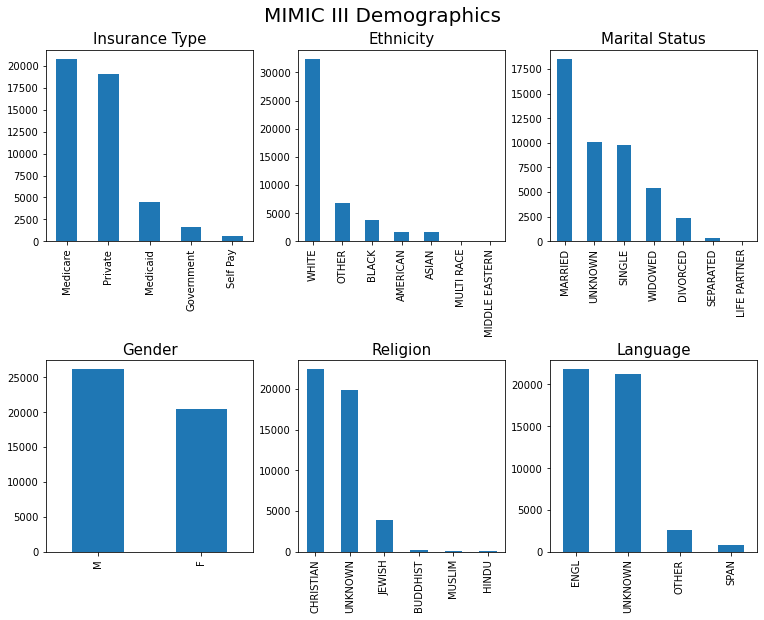

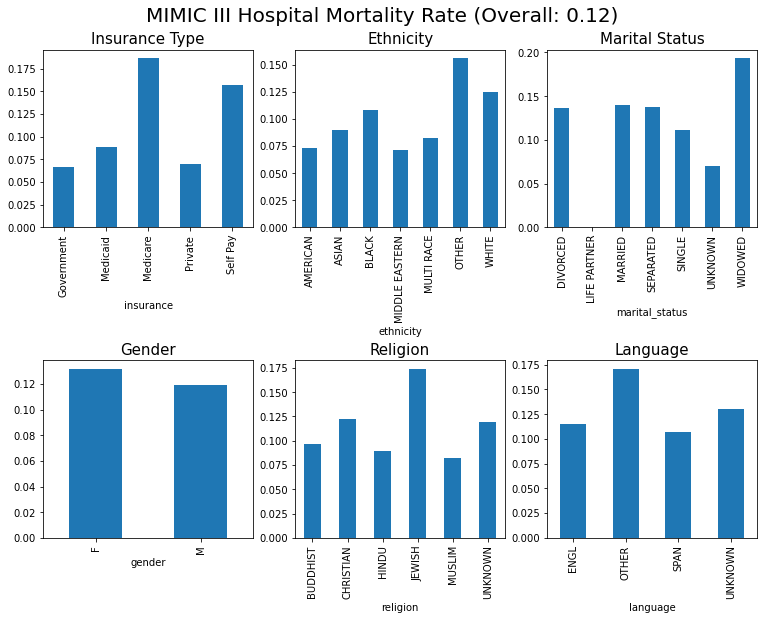

In [133]:
#Plot group demographics
group_plots('MIMIC III Demographics', 'count')

#Plot groups with mortality rate
mort_rate = df.hospital_expire_flag.mean()
mort_title = 'MIMIC III Hospital Mortality Rate (Overall: '+str(round(mort_rate,2))+')'
group_plots(mort_title, 'hospital_expire_flag')


In [134]:
#The following code prints out the data (mortality) that is plotted above

#group = df.groupby('insurance')
#print(group.hospital_expire_flag.mean())

#group = df.groupby('ethnicity')
#print(group.hospital_expire_flag.mean())

#group = df.groupby('marital_status')
#print(group.hospital_expire_flag.mean())

#group = df.groupby('gender')
#print(group.hospital_expire_flag.mean())

#group = df.groupby('religion')
#print(group.hospital_expire_flag.mean())

#group = df.groupby('language')
#print(group.hospital_expire_flag.mean())


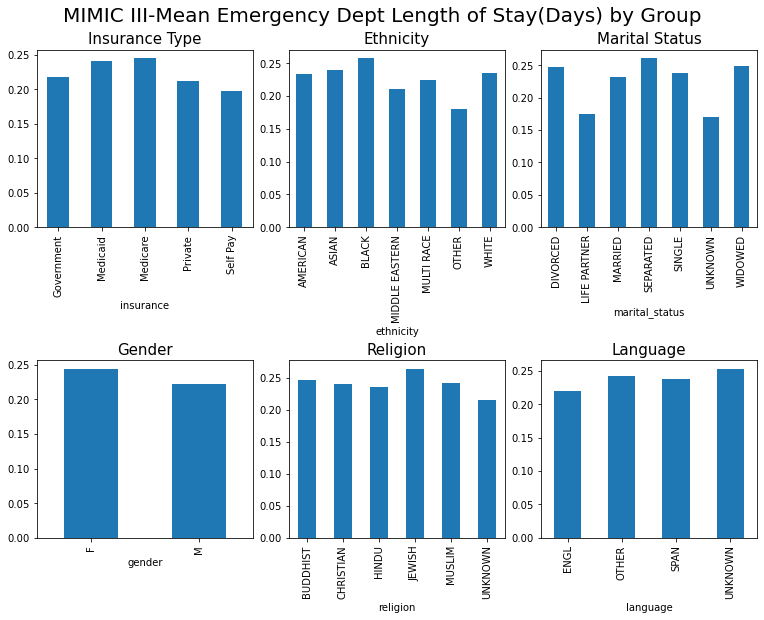

In [135]:
#Plot for avg LOS from ADMISSIONS df
group_plots('MIMIC III-Mean Emergency Dept Length of Stay(Days) by Group', 'los_avg_admis')


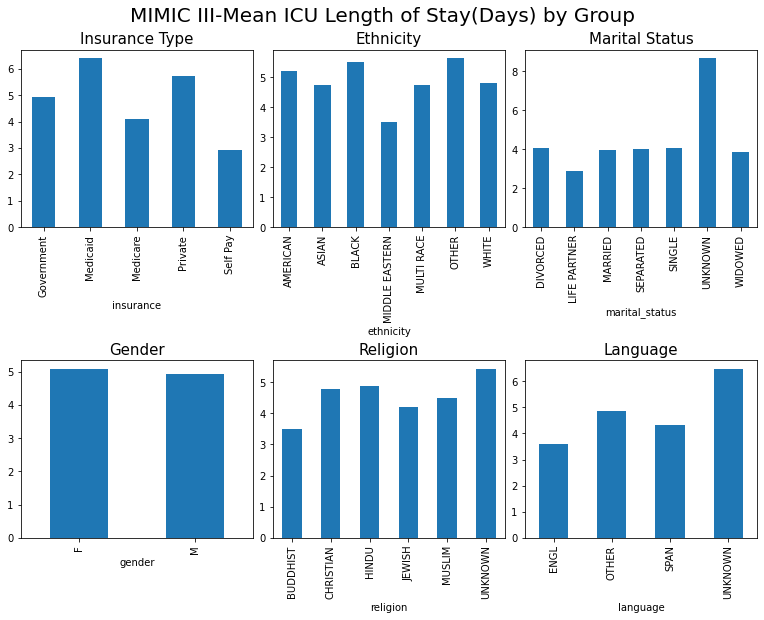

In [136]:
#Plot for avg LOS from ICU df
group_plots('MIMIC III-Mean ICU Length of Stay(Days) by Group', 'los_avg_icu')


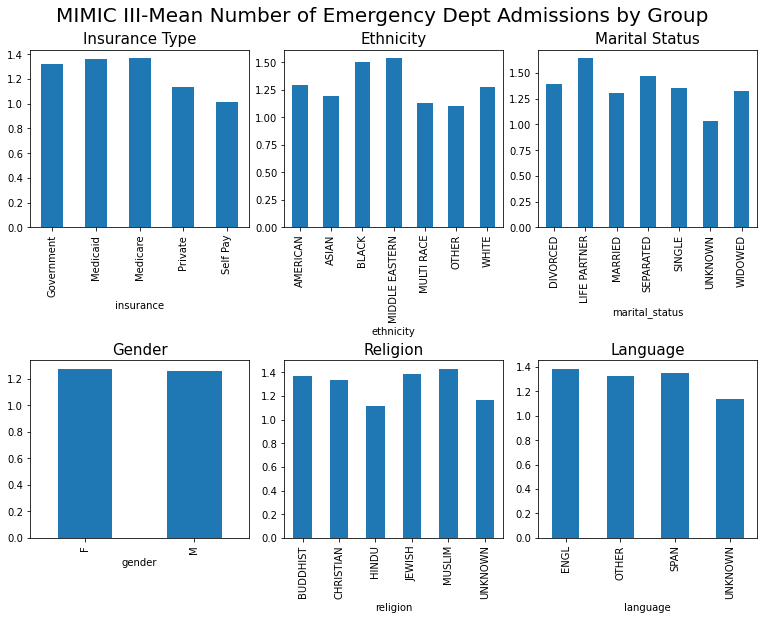

In [137]:
#Plot for num of admissions from ADMISSIONS df
group_plots('MIMIC III-Mean Number of Emergency Dept Admissions by Group', 'num_admis')


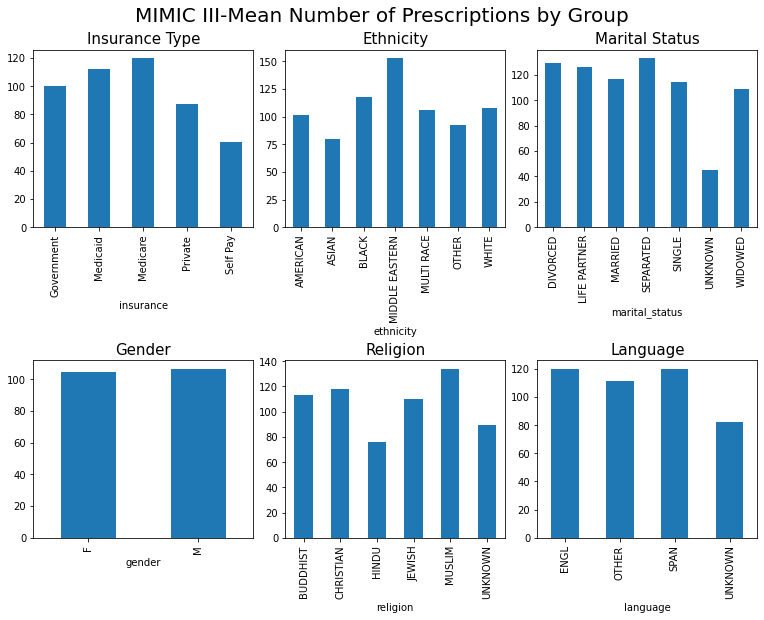

In [138]:
#Plot for num of prescriptions from PRESCRIPTIONS df
group_plots('MIMIC III-Mean Number of Prescriptions by Group', 'num_pres')


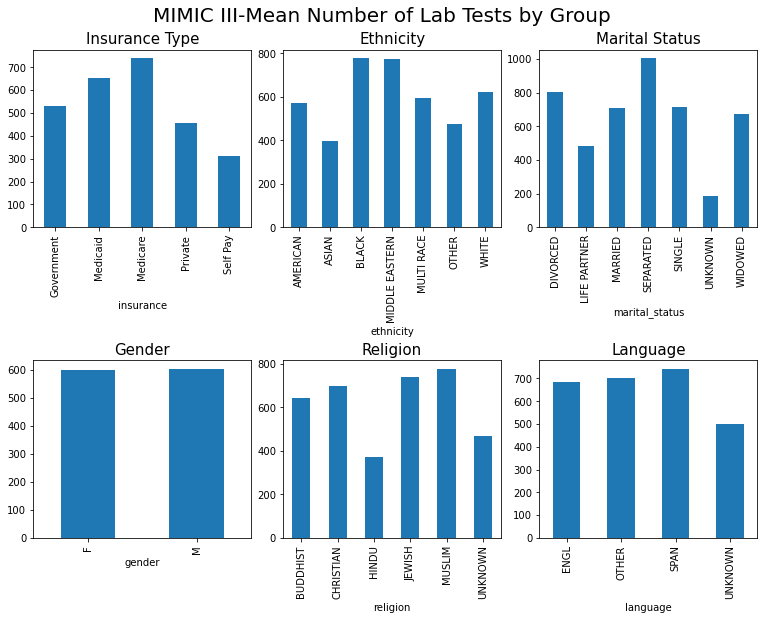

In [139]:
#Plot for num of lab tests from LABEVENTS df
group_plots('MIMIC III-Mean Number of Lab Tests by Group', 'num_labs')


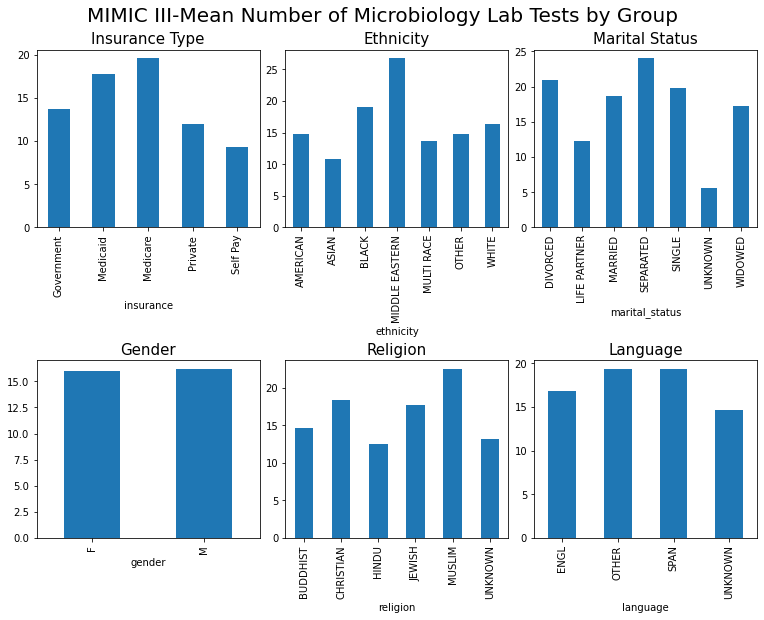

In [140]:
#Plot for num of lab tests from MICROBIOLOGYEVENTS df
group_plots('MIMIC III-Mean Number of Microbiology Lab Tests by Group', 'num_microbio_labs')


/tmp/ipykernel_12323/2592701969.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


subject_id  los_avg_admis  hospital_expire_flag  \
subject_id              1.000000      -0.085936             -0.002498   
los_avg_admis          -0.085936       1.000000             -0.008432   
hospital_expire_flag   -0.002498      -0.008432              1.000000   
num_admis              -0.033603       0.039594              0.077831   
los_avg_icu            -0.102113      -0.018727              0.031064   
num_pres                0.022273       0.055960              0.158478   
num_labs               -0.068866       0.057535              0.172279   
num_microbio_labs      -0.059560       0.032243              0.190083   

                      num_admis  los_avg_icu  num_pres  num_labs  \
subject_id            -0.033603    -0.102113  0.022273 -0.068866   
los_avg_admis          0.039594    -0.018727  0.055960  0.057535   
hospital_expire_flag   0.077831     0.031064  0.158478  0.172279   
num_admis              1.000000    -0.014359  0.637079  0.570852   
los_avg_icu           -0.014359     1.000000  0.169178  0.199101   
num_pres               0.637079     0.169178  1.000000  0.817512   
num_labs               0.570852     0.199101  0.817512  1.000000   
num_microbio_labs      0.450938     0.219649  0.743086  0.724300   

                      num_microbio_labs  
subject_id                    -0.059560  
los_avg_admis                  0.032243  
hospital_expire_flag           0.190083  
num_admis                      0.450938  
los_avg_icu                    0.219649  
num_pres                       0.743086  
num_labs                       0.724300  
num_microbio_labs              1.000000

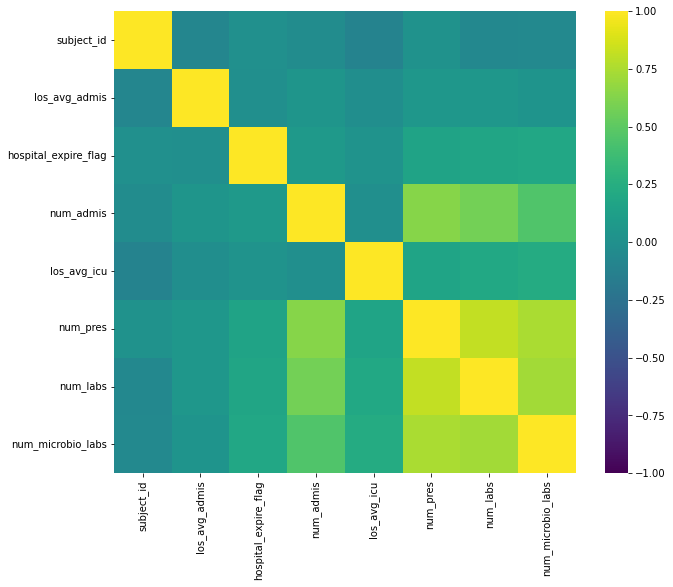

In [141]:

#look at correlation matrix for final dataframe
correlation_matrix = df.corr(method='pearson')
sns.heatmap(correlation_matrix, vmax=1.0, vmin=-1.0,square=True, cmap='viridis')
correlation_matrix

In [176]:
def bulk_anova(df_local, feature):
    """
    Runs the anova test on the given data and feature for each 
    demographic {insurance, ethnicity, marital status, gender, religion, language}

    Args:
        df: the dataframe for the anova
        feature: column of the dataframe for the anova test of the mean
    
    Return: 
        String - formatted anova test results
    """
    
    print("---------------------------"+feature+"---------------------------")
    
    # Performing two-way ANOVA
    model = ols(feature+' ~ insurance + ethnicity + marital_status + \
                gender + religion + language',
                data=df_local).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(result)
    
    pair_t1 = model.t_test_pairwise('insurance')
    pair_t2 = model.t_test_pairwise('ethnicity')
    pair_t3 = model.t_test_pairwise('marital_status')
    pair_t4 = model.t_test_pairwise('gender')
    pair_t5 = model.t_test_pairwise('religion')
    pair_t6 = model.t_test_pairwise('language')
    print("============================Pairwise test============================")
    print(pair_t1.result_frame)
    print(pair_t2.result_frame)
    print(pair_t3.result_frame)
    print(pair_t4.result_frame)
    print(pair_t5.result_frame)
    print(pair_t6.result_frame)

    return ""

In [177]:

 #los_avg_admis, num_admis, los_avg_icu, num_pres, num_labs, num_microbio_labs)

print(bulk_anova(df, 'los_avg_admis'))
print(bulk_anova(df, 'num_admis'))
print(bulk_anova(df, 'los_avg_icu'))
print(bulk_anova(df, 'num_pres'))
print(bulk_anova(df, 'num_labs'))
print(bulk_anova(df, 'num_microbio_labs'))


---------------------------los_avg_admis---------------------------
                     df       sum_sq   mean_sq          F        PR(>F)
insurance           4.0     5.996906  1.499226  25.346030  5.531537e-21
ethnicity           6.0     6.646959  1.107827  18.728995  7.330838e-22
marital_status      6.0     4.456645  0.742774  12.557392  3.438097e-14
gender              1.0     1.466194  1.466194  24.787589  6.445304e-07
religion            5.0     2.264161  0.452832   7.655613  3.361289e-07
language            3.0     7.852095  2.617365  44.249359  1.656845e-28
Residual        23930.0  1415.467794  0.059150        NaN           NaN
============================Pairwise test============================
                         coef   std err         t         P>|t|  \
Medicaid-Government  0.022169  0.009514  2.330226  1.980248e-02   
Medicare-Government  0.023221  0.008587  2.704042  6.855011e-03   
Private-Government  -0.002961  0.008725 -0.339399  7.343118e-01   
Self Pay-Governmen

                     df        sum_sq     mean_sq           F         PR(>F)
insurance           4.0    607.353861  151.838465  199.608661  4.885500e-170
ethnicity           6.0    373.733862   62.288977   81.885834  2.218980e-102
marital_status      6.0    364.684068   60.780678   79.903006  7.618562e-100
gender              1.0      0.070510    0.070510    0.092693   7.607819e-01
religion            5.0    146.112653   29.222531   38.416288   1.698745e-39
language            3.0    195.788161   65.262720   85.795152   2.351307e-55
Residual        46494.0  35367.090591    0.760681         NaN            NaN
============================Pairwise test============================
                         coef   std err          t         P>|t|  \
Medicaid-Government  0.049353  0.025387   1.943994  5.190214e-02   
Medicare-Government  0.034700  0.023312   1.488498  1.366264e-01   
Private-Government  -0.120697  0.023168  -5.209587  1.900666e-07   
Self Pay-Government -0.236986  0.043083  -

                     df        sum_sq       mean_sq           F         PR(>F)
insurance           4.0  3.758875e+04   9397.186480   98.175603   2.376149e-83
ethnicity           6.0  5.041207e+03    840.201226    8.777868   1.386615e-09
marital_status      6.0  1.449092e+05  24151.530663  252.319254  8.560280e-319
gender              1.0  1.035515e+02    103.551478    1.081838   2.982923e-01
religion            5.0  7.153087e+02    143.061743    1.494615   1.877898e-01
language            3.0  1.948812e+04   6496.039306   67.866332   8.773468e-44
Residual        46441.0  4.445246e+06     95.718144         NaN            NaN
============================Pairwise test============================
                         coef   std err         t         P>|t|  \
Medicaid-Government  1.377200  0.284894  4.834075  1.341930e-06   
Medicare-Government  0.062722  0.261590  0.239771  8.105092e-01   
Private-Government   0.289291  0.259973  1.112773  2.658117e-01   
Self Pay-Government -2.321067 

                     df        sum_sq       mean_sq           F         PR(>F)
insurance           4.0  1.012622e+07  2.531555e+06  185.720090  5.660270e-158
ethnicity           6.0  1.909320e+06  3.182199e+05   23.345268   1.088555e-27
marital_status      6.0  1.923623e+07  3.206039e+06  235.201587  1.973546e-296
gender              1.0  4.243261e+04  4.243261e+04    3.112943   7.768023e-02
religion            5.0  2.528799e+06  5.057598e+05   37.103578   4.379005e-38
language            3.0  3.300426e+06  1.100142e+06   80.708678   4.770552e-52
Residual        39337.0  5.362036e+08  1.363102e+04         NaN            NaN
============================Pairwise test============================
                          coef   std err          t         P>|t|  \
Medicaid-Government  15.023720  3.736145   4.021182  5.801481e-05   
Medicare-Government  14.164462  3.399819   4.166240  3.103253e-05   
Private-Government   -8.328658  3.409176  -2.443012  1.456962e-02   
Self Pay-Government -2

                     df        sum_sq       mean_sq           F         PR(>F)
insurance           4.0  8.686388e+08  2.171597e+08  265.678591  3.660060e-226
ethnicity           6.0  2.696182e+08  4.493637e+07   54.976273   5.746239e-68
marital_status      6.0  1.554785e+09  2.591309e+08  317.027226   0.000000e+00
gender              1.0  3.487761e+05  3.487761e+05    0.426701   5.136152e-01
religion            5.0  1.982790e+08  3.965581e+07   48.515904   2.926457e-50
language            3.0  1.966814e+07  6.556048e+06    8.020833   2.431063e-05
Residual        46226.0  3.778409e+10  8.173775e+05         NaN            NaN
============================Pairwise test============================
                           coef    std err          t         P>|t|  \
Medicaid-Government  151.501552  26.402712   5.738106  9.633792e-09   
Medicare-Government  146.279530  24.239150   6.034846  1.603220e-09   
Private-Government    -7.718466  24.101846  -0.320244  7.487850e-01   
Self Pay-Gover

                     df        sum_sq        mean_sq           F  \
insurance           4.0  5.174428e+05  129360.694252  133.259967   
ethnicity           6.0  7.155037e+04   11925.061795   12.284515   
marital_status      6.0  8.452368e+05  140872.796739  145.119075   
gender              1.0  1.909244e+02     190.924361    0.196679   
religion            5.0  6.956681e+04   13913.361618   14.332747   
language            3.0  1.429992e+05   47666.395241   49.103186   
Residual        39158.0  3.801221e+07     970.739352         NaN   

                       PR(>F)  
insurance       2.845151e-113  
ethnicity        7.305866e-14  
marital_status  9.074840e-183  
gender           6.574171e-01  
religion         4.756724e-14  
language         1.149001e-31  
Residual                  NaN  
============================Pairwise test============================
                         coef   std err          t         P>|t|  \
Medicaid-Government  4.743853  0.974537   4.867801  1.132856e

In [179]:
import plotly.express as px

df = px.data.gapminder()
fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp", size="pop", color="continent",
           hover_name="country", log_x=True, size_max=60)
fig.show()

In [ ]:
#look at diagnosis for categories - the documentation said that one should not 
# try to stratify data on this field, so didn't do this

# Future work would include:
#num of procedures - procedures_icd table
#look at age groups - do if more time
#long term mortality - do if more time
#      create new plot for long term mortalities, different for different groups?
# look at 50s, white male. How many are alive long term? Is it less?